# Make Figures for Model Validation: Multi Cycles

5/9/2023

Andrew Weng

In [1]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter

%load_ext autoreload

# Load the Experimental Data

In [2]:
plotter.initialize(plt)
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'

# To make the dQ/dV plot work, be sure to only select the FORM protocol without 
# including the aging file. Otherwise the time vector will be confused.
file_indices_to_include = np.array([1,2])

cellid = 152064

if cellid == 152064:
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 20*24

elif cellid == 152074: # BASELINE FORMATION (repeat 2)
    
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 20*24

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

# Filter the Arbin Data
ii = df_arbin['Current (A)']
qq = df_arbin['Charge Capacity (Ah)']
tv = df_arbin['Timestamp'].astype(int)
tv = (tv - np.min(tv)) / 1e9
y_voltage = df_arbin['Potential (V)']

y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN

# Load the Keyence data
file_keyence = f'{target_dir}/data/raw/from-keyence/keyence_20220901_213928.csv'
df_keyence = pd.read_csv(file_keyence)
df_keyence['computer time'] = pd.to_datetime(df_keyence['computer time'], unit='s')
df_keyence['computer time'] = df_keyence['computer time'].apply(lambda x : x.tz_localize(None))

# Filter the Keyence data
df_keyence = df_keyence.loc[(df_keyence['computer time'] > df_arbin['Timestamp'].iloc[0]) & \
                            (df_keyence['computer time'] < df_arbin['Timestamp'].iloc[-1])]
y_strain = df_keyence[daq_channel] - df_keyence[daq_channel].iloc[0]
y_strain[y_strain > 500] = np.NaN

tt = df_keyence['computer time'].astype(int)
tt = (tt - np.min(tt)) / 1e9

y_strain.iloc[np.where(tt/3600 > hr_max)] = np.NaN

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_21202/315753491.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN


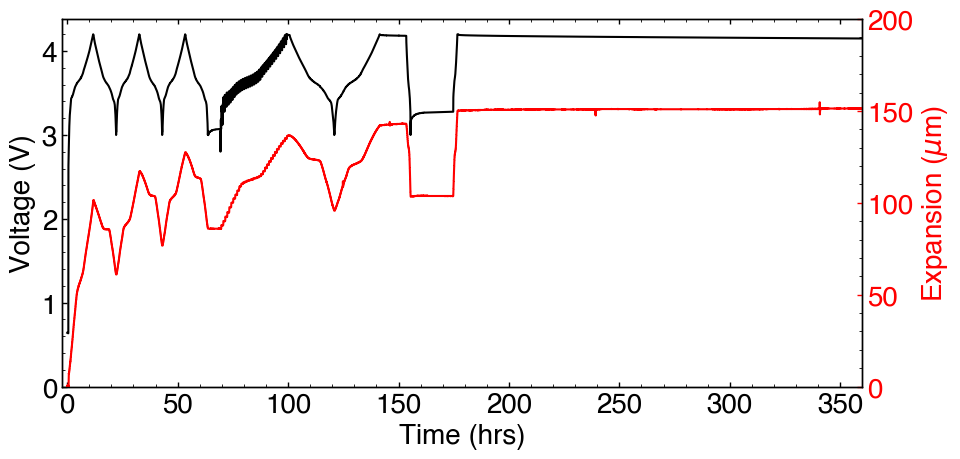

In [3]:
plt.figure(figsize=(10,5))

# The voltage plot
ax1 = plt.subplot()
ax1.plot(tv/3600, y_voltage, color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
ax1.set_xlim((-0.1 * 24, 15 * 24))

# The expansion plot
ax2 = ax1.twinx()
ax2.plot(tt/3600, y_strain, color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0, top=200)
ax2.grid(False)

plt.savefig(f'outputs/figures/fig_strain_vs_voltage_cell{cellid}.png', dpi=300)

# Run the simulation

In [4]:
%autoreload 
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/single_cracking.yaml')
tag = cell.get_tag()

# sim = cellsim.Simulation(cell, 520*3600)
sim = cellsim.Simulation(cell, 24*20*3600)

# Formation
sim.run_rest(1, rest_time_hrs=0.5)
sim.run_chg_cccv(2, 2.5/10, Icv, vmax)
sim.run_dch_cccv(2, Idch, Idch, vmin)
sim.run_chg_cccv(3, 2.5/10, Icv, vmax)
sim.run_dch_cccv(3, Idch, Idch, vmin)
sim.run_chg_cccv(4, 2.5/10, Icv, vmax)
sim.run_dch_cccv(4, Idch, Idch, vmin)
sim.run_rest(4, rest_time_hrs=6)

# RPT
sim.run_chg_cccv(5, +2.5/30, +2.5/30, vmax) # Approximate HPPC Pulse Charge
sim.run_dch_cccv(5, -2.5/20, Icv, vmin)
sim.run_chg_cccv(6, +2.5/20, Icv, vmax)
sim.run_rest(6, rest_time_hrs=9)
sim.run_dch_cccv(7, -2.5/6, Idch, vmin) # Note (1)
sim.run_rest(7, rest_time_hrs=17)

# Note (1): can't seem to run any higher than C/6 right now without running into
# issues with numerical instability. Some of the variables start to oscillate.

# Aging
sim.run_chg_cccv(8, 2.5/6, Icv, vmax)
sim.run_rest(8, rest_time_hrs=7*24)
sim.run_dch_cccv(8, -2.5/20, -2.5/20, vmin)

df_sim = sim.get_results()

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc4: Rest for 6 hours...
Running Cyc5: Charge to 4.2V...
Running Cyc5: Discharge to 3.0V...
Running Cyc6: Charge to 4.2V...
Running Cyc6: Rest for 9 hours...
Running Cyc7: Discharge to 3.0V...
Running Cyc7: Rest for 17 hours...
Running Cyc8: Charge to 4.2V...
Running Cyc8: Rest for 168 hours...
Running Cyc8: Discharge to 3.0V...


/Users/aweng/code/formation-modeling/src/cellsim.py:803: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/{self.name}_output.png',
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


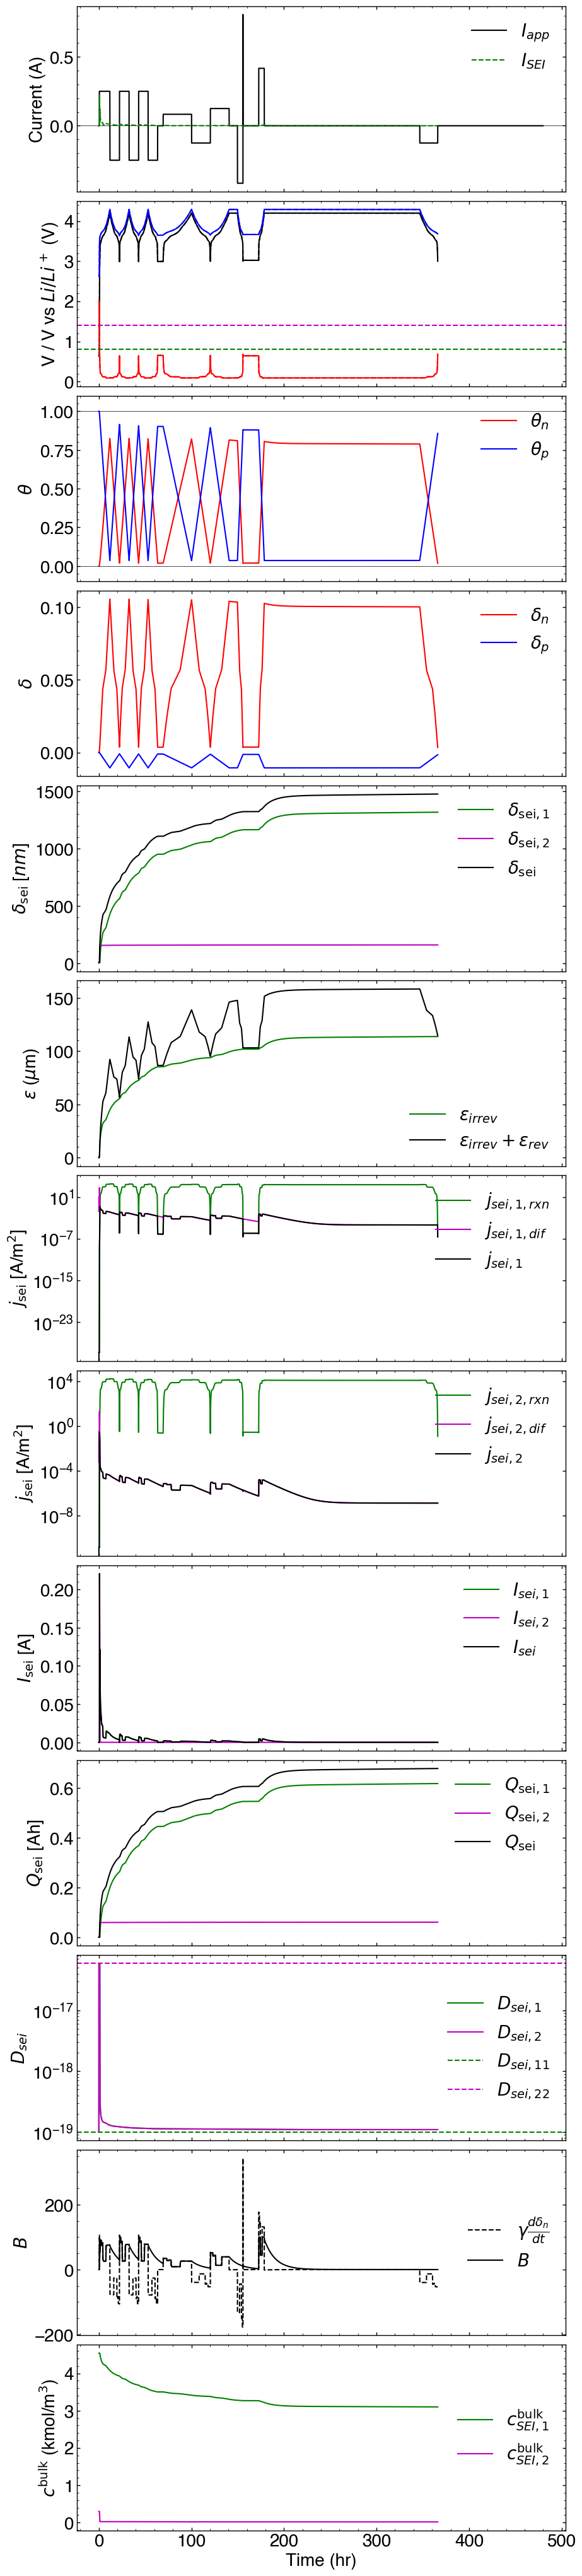

In [5]:
# %matplotlib widget
%autoreload
sim.plot()

# Compare Voltages

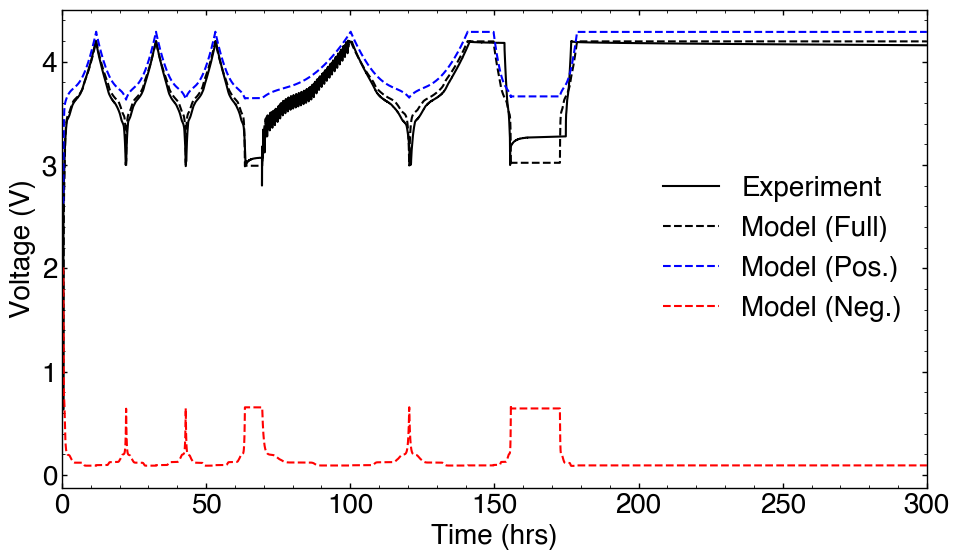

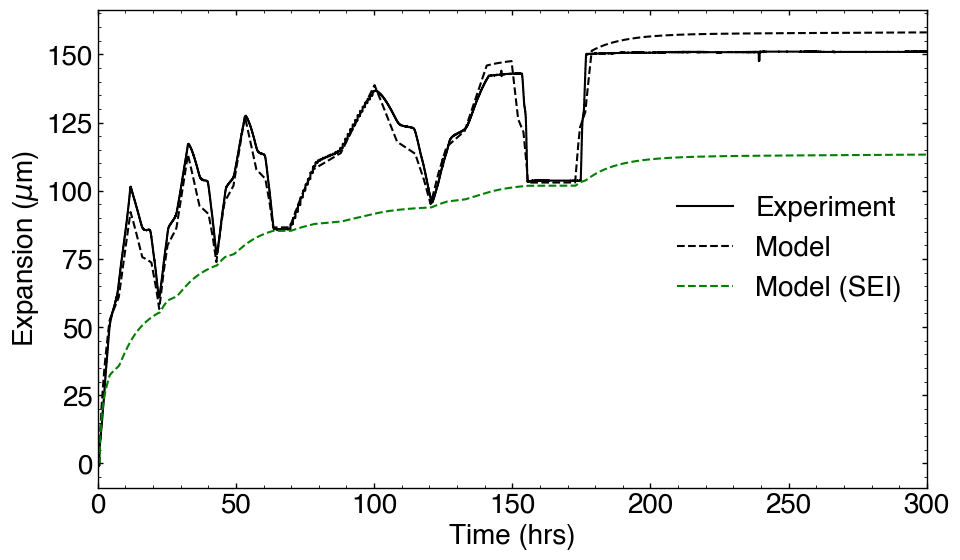

In [6]:
exp_sim = df_sim['expansion_rev'] + df_sim['expansion_irrev']
v_sim = df_sim['vt']
t_sim = df_sim['t']

plt.figure(figsize=(10,6))
plt.grid(False)
plt.plot(tv/3600, y_voltage, c='k', label='Experiment')
plt.plot(t_sim/3600, df_sim['vt'], c='k', ls='--', label='Model (Full)')
plt.plot(t_sim/3600, df_sim['ocv_p'] + df_sim['eta_p'], c='b', ls='--', label='Model (Pos.)')
plt.plot(t_sim/3600, df_sim['ocv_n'] - df_sim['eta_n'], c='r', ls='--', label='Model (Neg.)')
plt.legend(loc='right', fontsize=20)
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
plt.xlim((0, 300))
plt.savefig(f'outputs/figures/fig_v_{tag}.png')

plt.figure(figsize=(10,6))
plt.grid(False)
plt.plot(tt/3600, y_strain, c='k', label='Experiment')
plt.plot(t_sim/3600, (df_sim['expansion_rev'] + df_sim['expansion_irrev'])*1e6, c='k', ls='--', label='Model')
plt.plot(t_sim/3600, (df_sim['expansion_irrev'])*1e6, c='g', ls='--', label='Model (SEI)')
plt.xlabel('Time (hrs)')
plt.ylabel('Expansion ($\mu$m)')
plt.legend(loc='right', fontsize=20)
plt.xlim((0, 300))
plt.savefig(f'outputs/figures/fig_exp_{tag}.png')

# Compare the coulombic efficiency at each cycle

In [7]:
df_sim

,name,cell,dt,t,curr_k,i_app,cycle_number,step_number,theta_n,theta_p,...,delta_n,delta_p,dndt,boost,expansion_rev,expansion_irrev,dq,dqsei,dqsei1,dqsei2
0,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,0.0,131802,0.0,1.0,4.0,0.000000e+00,1.0,...,0.000000e+00,-0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,10.0,131802,0.0,1.0,4.0,0.000000e+00,1.0,...,0.000000e+00,-0.0,0.000000e+00,0.0,0.000000e+00,3.850000e-07,0.0,3.438562e-14,4.239831e-32,3.438562e-14
2,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,20.0,131802,0.0,1.0,4.0,-1.095084e-14,1.0,...,-2.190167e-15,-0.0,-2.190167e-16,0.0,-1.095084e-18,3.850000e-07,0.0,3.438563e-14,4.239831e-32,3.438563e-14
3,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,30.0,131802,0.0,1.0,4.0,-2.190167e-14,1.0,...,-4.380334e-15,-0.0,-2.190167e-16,0.0,-2.190167e-18,3.850000e-07,0.0,3.438563e-14,4.239831e-32,3.438563e-14
4,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,40.0,131802,0.0,1.0,4.0,-3.285251e-14,1.0,...,-6.570502e-15,-0.0,-2.190167e-16,0.0,-3.285251e-18,3.850000e-07,0.0,3.438563e-14,4.239831e-32,3.438563e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172795,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,1727950.0,131802,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
172796,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,1727960.0,131802,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
172797,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,1727970.0,131802,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
172798,DefaultSim,<src.cellsim.Cell object at 0x10befc1f0>,10.0,1727980.0,131802,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [8]:
# Measured coulombic efficiency
df_meas_agg = df_arbin.groupby(['Cycle Number'])['Charge Capacity (Ah)', 'Discharge Capacity (Ah)'].agg('max')
df_meas_agg = df_meas_agg.iloc[0:3]
df_meas_agg['ce'] = df_meas_agg['Discharge Capacity (Ah)'] / df_meas_agg['Charge Capacity (Ah)']

# Simulated coulombic efficiency
df_agg = df_sim.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
df_min = df_sim.groupby(['cycle_number'])['theta_n'].agg('min')
df_max = df_sim.groupby(['cycle_number'])['theta_p'].agg('max')

print(df_min[0])


0.017215323905927102


/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_21202/3226942346.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_meas_agg = df_arbin.groupby(['Cycle Number'])['Charge Capacity (Ah)', 'Discharge Capacity (Ah)'].agg('max')


cycle_number  step_number
0.0           0.0            0.000000
1.0           4.0            0.000000
2.0           0.0            2.840972
              1.0            0.005087
              2.0            2.594444
3.0           0.0            2.589583
              1.0            0.004972
              2.0            2.571528
4.0           0.0            2.566667
              1.0            0.004920
              2.0            2.557639
              4.0            0.000000
5.0           0.0            2.559491
              2.0            2.535069
6.0           0.0            2.533333
              4.0            0.000000
7.0           2.0            2.494213
              4.0            0.004067
8.0           0.0            2.480324
              1.0            0.011155
              2.0            2.424306
              4.0            0.000005
Name: dq, dtype: float64


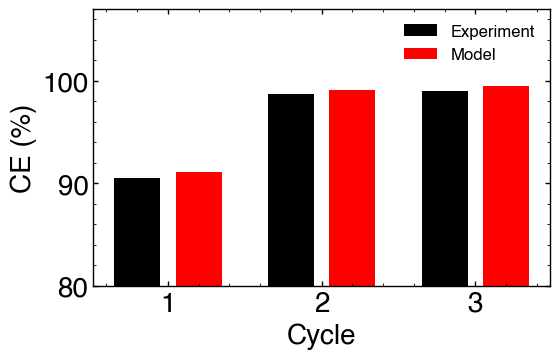

<Figure size 1400x1200 with 0 Axes>

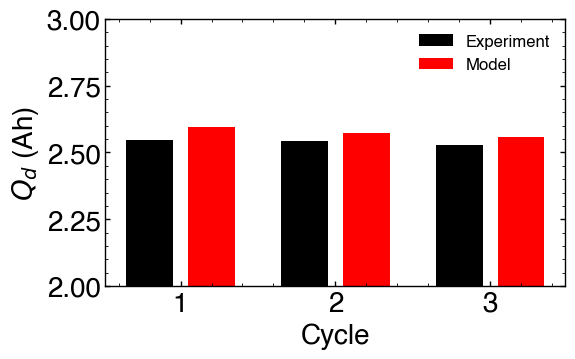

<Figure size 1400x1200 with 0 Axes>

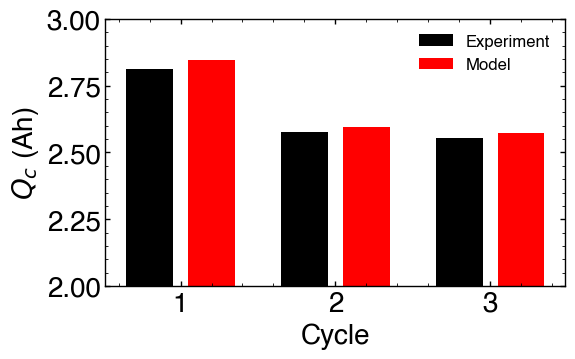

<Figure size 1400x1200 with 0 Axes>

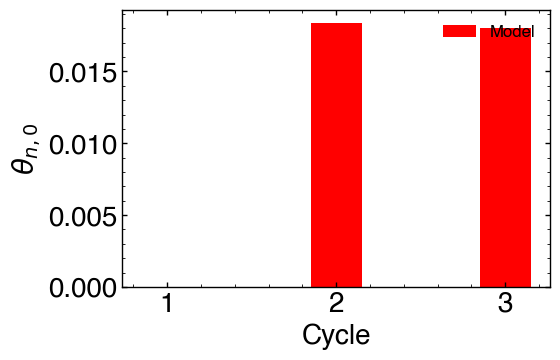

<Figure size 1400x1200 with 0 Axes>

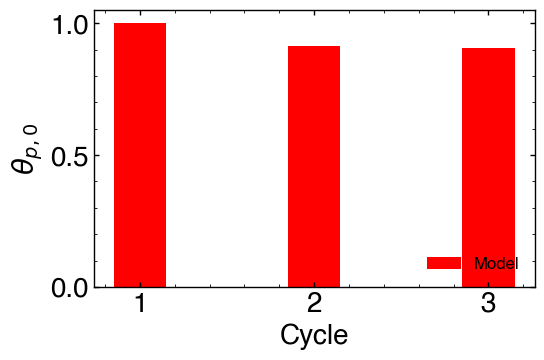

<Figure size 1400x1200 with 0 Axes>

In [15]:

print(df_agg)
ce_sim = []
qc_sim = []
qd_sim = []
theta_p0_sim = []
theta_n0_sim = []
cycle_index = np.array([2, 3, 4])
for i in cycle_index:
    qd_sim.append(df_agg[i][2])
    qc_sim.append(df_agg[i][0] + df_agg[i][1])
    ce_sim.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))
    theta_p0_sim.append(df_max[i])
    theta_n0_sim.append(df_min[i])

ce_sim = np.array(ce_sim)
qc_sim = np.array(qc_sim)
qd_sim = np.array(qd_sim)
theta_p0_sim = np.array(theta_p0_sim)
theta_n0_sim = np.array(theta_n0_sim)

# Make the plot
plt.figure(figsize=(6, 4))
xx = np.array([1, 2, 3])
plt.bar(xx-0.2, df_meas_agg['ce']*100, color='k', width=0.3, label='Experiment')
plt.bar(xx+0.2, ce_sim*100, color='r', width=0.3, label='Model')
plt.ylabel('CE (%)')
plt.xlabel('Cycle')
plt.grid(False)
plt.legend(loc='upper right', fontsize=16)
plt.ylim([80, 107])
plt.show()
plt.savefig(f'outputs/figures/fig_ce_{tag}.png')

# Make the plot
plt.figure(figsize=(6, 4))
xx = np.array([1, 2, 3])
plt.bar(xx-0.2, df_meas_agg['Discharge Capacity (Ah)'], color='k', width=0.3, label='Experiment')
plt.bar(xx+0.2, qd_sim, color='r', width=0.3, label='Model')
plt.ylabel('$Q_d$ (Ah)')
plt.xlabel('Cycle')
plt.grid(False)
plt.ylim((2, 3))
plt.legend(loc='upper right', fontsize=16)
plt.show()
plt.savefig(f'outputs/figures/fig_qd_{tag}.png')

# Make the plot
plt.figure(figsize=(6, 4))
xx = np.array([1, 2, 3])
plt.bar(xx-0.2, df_meas_agg['Charge Capacity (Ah)'], color='k', width=0.3, label='Experiment')
plt.bar(xx+0.2, qc_sim, color='r', width=0.3, label='Model')
plt.ylabel('$Q_c$ (Ah)')
plt.xlabel('Cycle')
plt.grid(False)
plt.legend(loc='upper right', fontsize=16)
plt.ylim([2, 3])
plt.show()
plt.savefig(f'outputs/figures/fig_qc_{tag}.png')

# Make the plot
plt.figure(figsize=(6, 4))
xx = np.array([1, 2, 3])
plt.bar(xx, theta_n0_sim, color='r', width=0.3, label='Model')
# plt.hlines(y=0.01, xmin=1, xmax=3, color='k', label='dV/dQ, post-formation')
plt.ylabel(r'$\theta_{n,0}$')
plt.xlabel('Cycle')
plt.grid(False)
plt.legend(loc='upper right', fontsize=12)
plt.show()
plt.savefig(f'outputs/figures/fig_thetan_{tag}.png')

# Make the plot
plt.figure(figsize=(6, 4))
xx = np.array([1, 2, 3])
plt.bar(xx, theta_p0_sim, color='r', width=0.3, label='Model')
# plt.hlines(y=0.842, xmin=1, xmax=3, color='k', label='dV/dQ, post-formation')
plt.ylabel(r'$\theta_{p,0}$')
plt.xlabel('Cycle')
plt.grid(False)
plt.legend(loc='lower right', fontsize=16)
plt.show()
plt.savefig(f'outputs/figures/fig_thetap_{tag}.png')


Text(0, 0.5, '$U_n$')

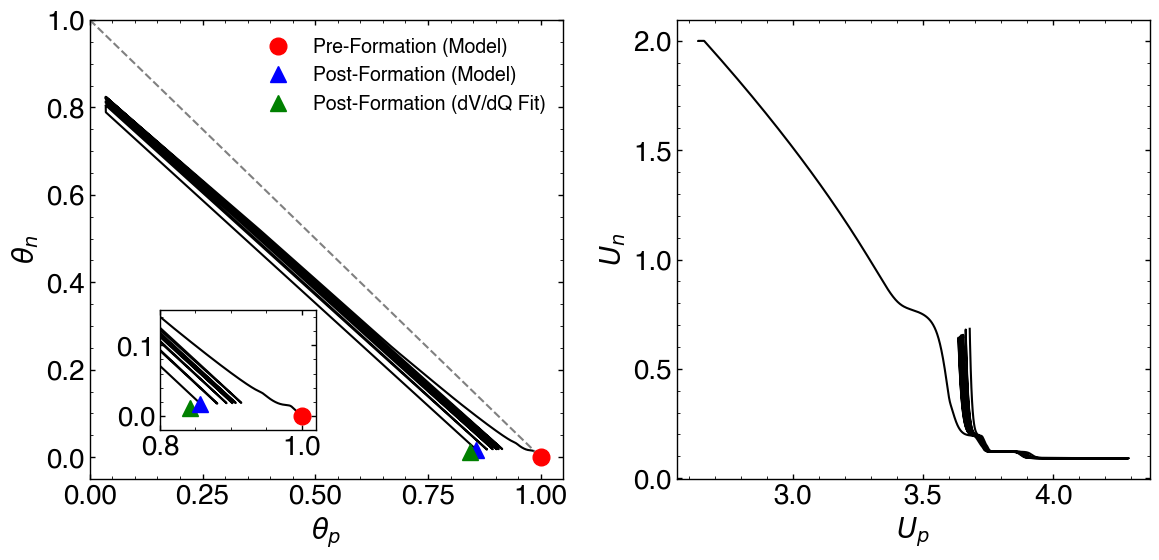

In [17]:
# Measured values from cell152002 (Hamid's fit)
x0 = 0.0108 
y0 = 0.84244

fh, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

xx = np.linspace(0, 1, 100)
ax0.plot(sim.theta_p, sim.theta_n, c='k')
ax0.plot(xx, 1-xx, c=(0.5,0.5,0.5), ls='--')
ax0.plot(1, 0, marker='o', color='r', ms=12, ls='', label='Pre-Formation (Model)')
ax0.plot(sim.theta_p[sim.curr_k-1], sim.theta_n[sim.curr_k-1], marker='^', c='b', ls='', ms=12, label='Post-Formation (Model)')
ax0.plot(y0, x0, marker='^', color='g', ms=12, ls='', label='Post-Formation (dV/dQ Fit)')
ax0.set_xlabel(r'$\theta_p$')
ax0.set_ylabel(r'$\theta_n$')
ax0.grid(False)
ax0.set_xlim((0,1.05))
ax0.set_ylim((-0.05,1))
ax0.legend(fontsize=14)

left, bottom, width, height = [0.15, 0.25, 0.13, 0.2]
ax2 = fh.add_axes([left, bottom, width, height])
ax2.plot(sim.theta_p, sim.theta_n, c='k')
ax2.plot(1, 0, marker='o', color='r', ms=12)
ax2.plot(y0, x0, marker='^', color='g', ms=12)
ax2.plot(sim.theta_p[sim.curr_k-1], sim.theta_n[sim.curr_k-1], marker='^', c='b', ls='', ms=12)
ax2.grid(False)
ax2.set_xbound(lower=0.8, upper=1.02)
ax2.set_ybound(lower=-0.02, upper=0.15)

ax1.plot(sim.ocv_p, sim.ocv_n, c='k')
ax1.grid(False)
ax1.set_xlabel(r'$U_p$')
ax1.set_ylabel(r'$U_n$')